In [1]:
import os
import json
from pathlib import Path
from tempfile import TemporaryFile

import numpy as np
from sklearn.manifold import TSNE
import pyvista as pv
import pandas as pd
from tqdm.auto import tqdm
import seaborn as sb
import matplotlib.pyplot as plt
from PIL import Image

/home/max/miniconda3/envs/dev/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data_dir = Path("/home/max/Desktop/python_projects/")
root = data_dir / "SimJEB_surfmesh"
dest = data_dir / "SimJEB_sdf"

In [4]:
paths = []
for path in root.glob("*.obj"):
    paths.append(path)

In [22]:
len(paths)

381

In [24]:
stats = []
for path in tqdm(paths):
    mesh = pv.read(path)
    xmin, xmax, ymin, ymax, zmin, zmax = mesh.bounds
    stats.append({
        "id": path.stem,
        "xmin": xmin,
        "xmax": xmax,
        "ymin": ymin,
        "ymax": ymax,
        "zmin": zmin,
        "zmax": zmax,
    })

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 381/381 [01:38<00:00,  3.88it/s]


In [26]:
stats = pd.DataFrame(stats)
stats.to_csv(root / "stats.csv")

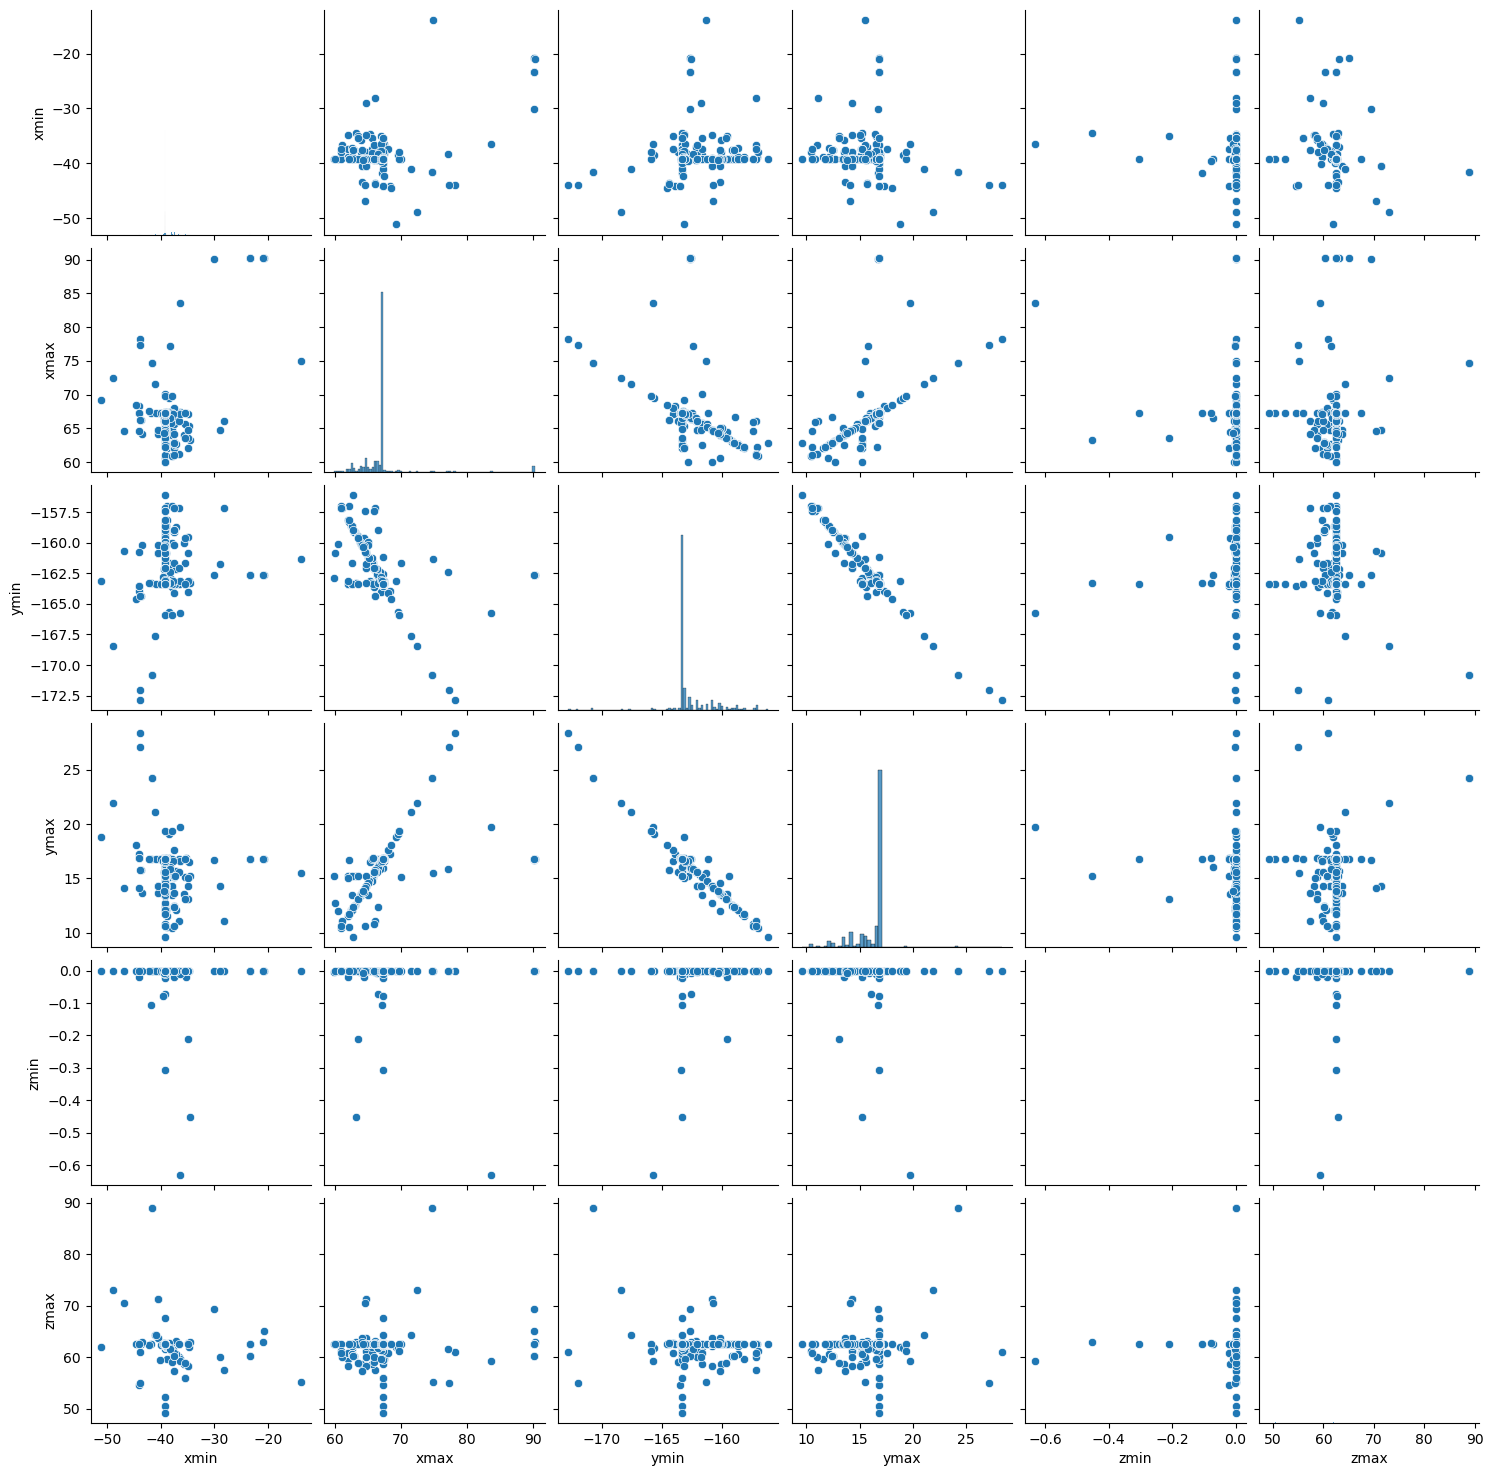

In [30]:
sb.pairplot(stats)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 381/381 [01:42<00:00,  3.73it/s]


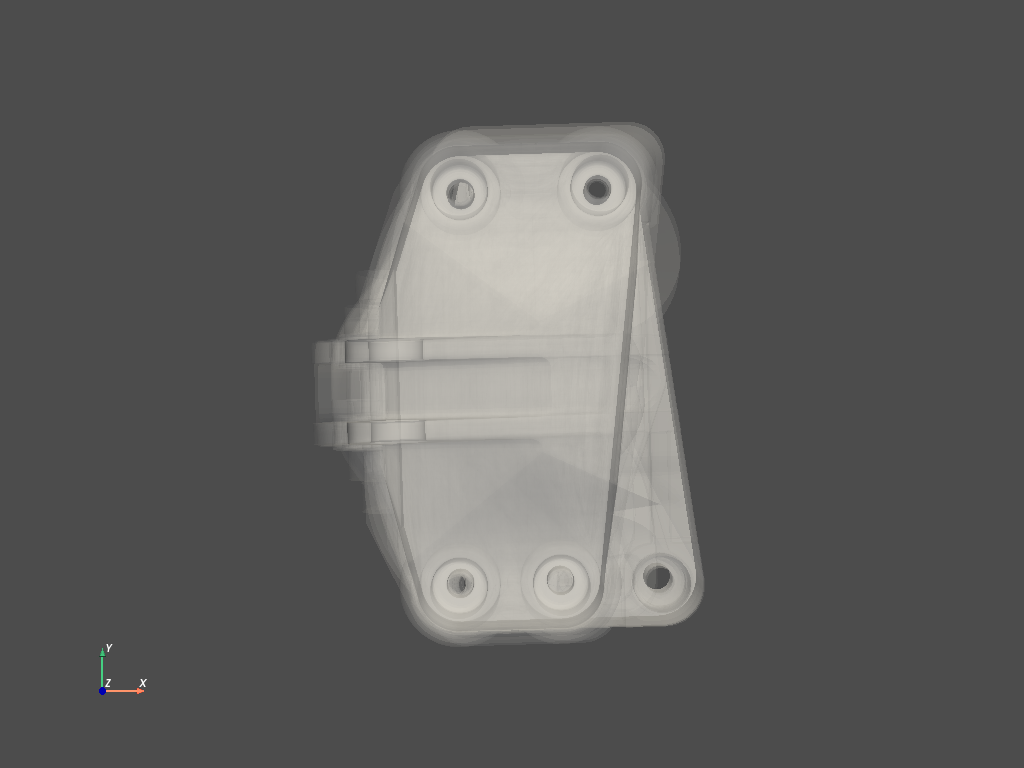

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 381/381 [02:42<00:00,  2.34it/s]


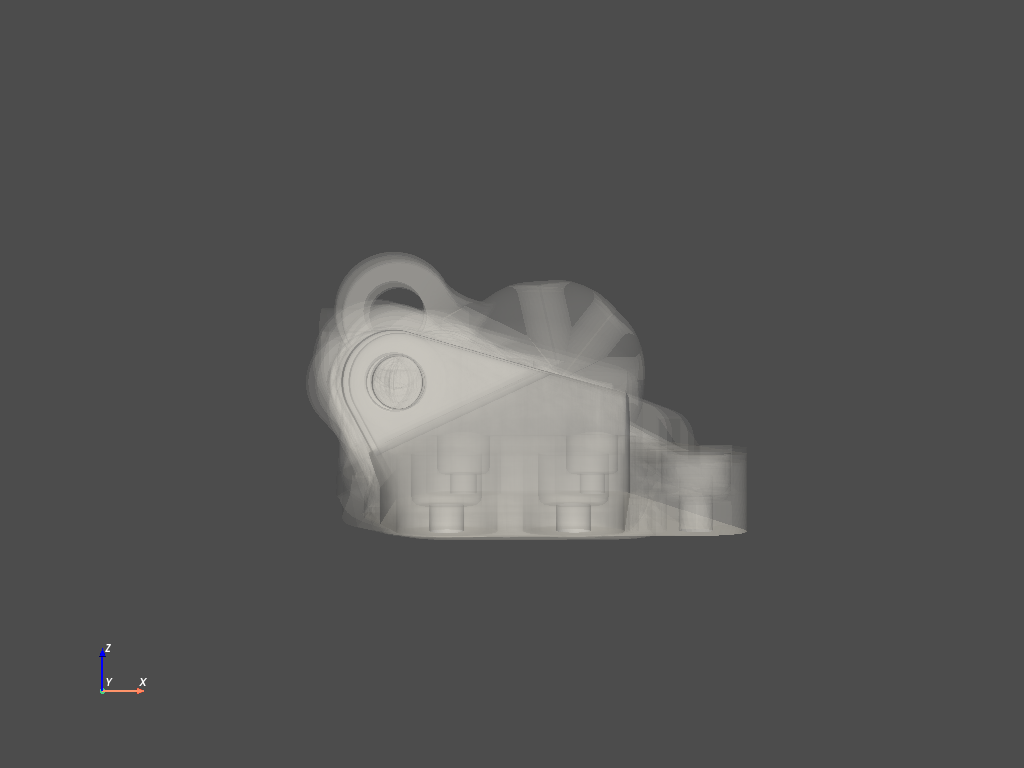

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 381/381 [01:49<00:00,  3.48it/s]


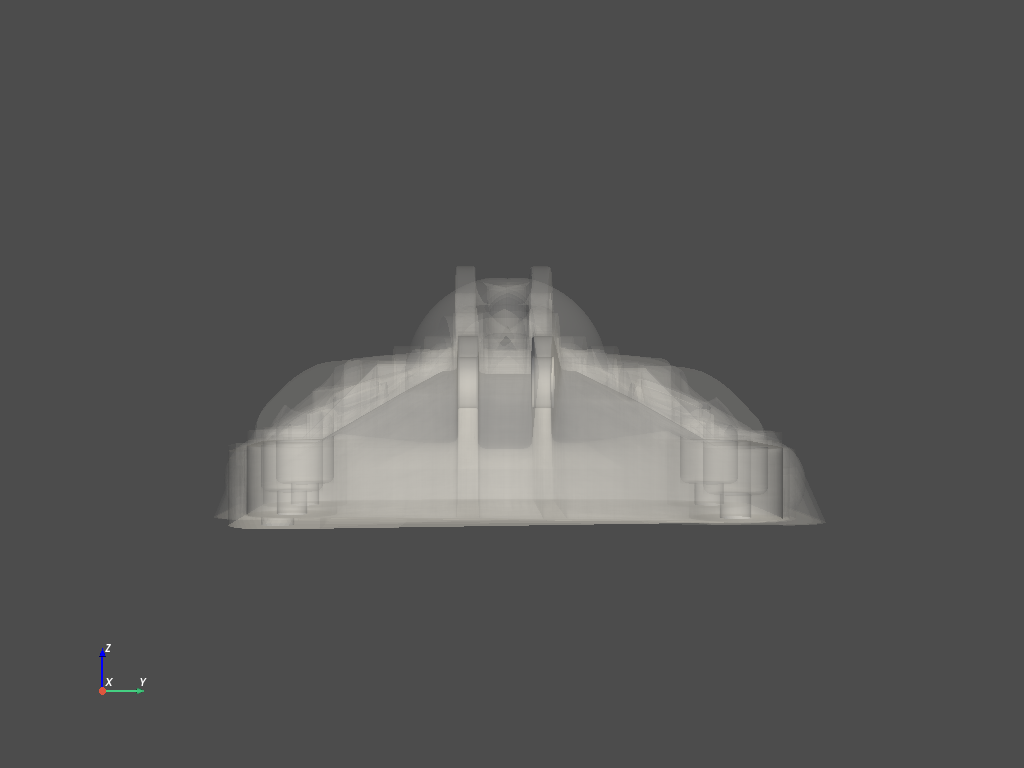

In [36]:
for view in ["xy", "xz", "yz"]:
    
    pl = pv.Plotter()

    # Load each mesh, set transparency, and add it to the plotter
    for path in tqdm(paths):
        mesh = pv.read(path)

        # Add the mesh to the plotter
        pl.add_mesh(mesh, opacity=0.1)

    # Set the camera position to view
    pl.camera_position = view
    pl.add_axes()
    pl.show_axes_all()
    pl.show(auto_close=False)
    image = pl.screenshot(None, return_img=True)
    Image.fromarray(pl.screenshot(None, return_img=True)).save(f"{view}.jpeg")

Notes:
1. quite well centered, no clear outliers
2. still not same position: attachment points are not in the same location

In [37]:
points = []
for path in tqdm(paths):
    mesh = pv.read(path)
    points.append(mesh.points)
points = np.vstack(points)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 381/381 [01:44<00:00,  3.64it/s]


In [38]:
pv_points = pv.PolyData(points)
pv_points.save(data_dir / "SimJEB_metadata" / "all_points.vtk")

In [39]:
len(pv_points.points)

14033651

In [5]:
def random_downsample_pointcloud(pointcloud, target_num_points):
    """
    Randomly downsample a PyVista point cloud to a specified number of points.

    Parameters:
    - pointcloud (pyvista.PolyData): Input point cloud.
    - target_num_points (int): Target number of points in the downsampled point cloud.

    Returns:
    - pyvista.PolyData: Downsampled point cloud.
    """
    # Get the number of points in the original point cloud
    total_points = pointcloud.n_points

    # Check if the target number of points is greater than the total number of points
    if target_num_points >= total_points:
        return pointcloud  # No downsampling needed

    # Generate random indices for the downsampled point cloud
    random_indices = np.random.choice(total_points, size=target_num_points, replace=False)

    # Extract the selected points from the original point cloud
    downsampled_points = pointcloud.points[random_indices]

    # Create a new PyVista point cloud with the downsampled points
    downsampled_pointcloud = pv.PolyData(downsampled_points)

    return downsampled_pointcloud

In [41]:
pv_points_downsample = random_downsample_pointcloud(pv_points, 2000000)
pv_points_downsample.save(data_dir / "SimJEB_metadata" / "all_points_2M.vtk")

In [6]:
pv_points_downsample = random_downsample_pointcloud(
    pv.read(data_dir / "SimJEB_metadata" / "all_points_2M.vtk"),
    1000000
)

In [7]:
pv_points_downsample.save(data_dir / "SimJEB_metadata" / "all_points_1M.vtk")

/home/max/miniconda3/envs/dev/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


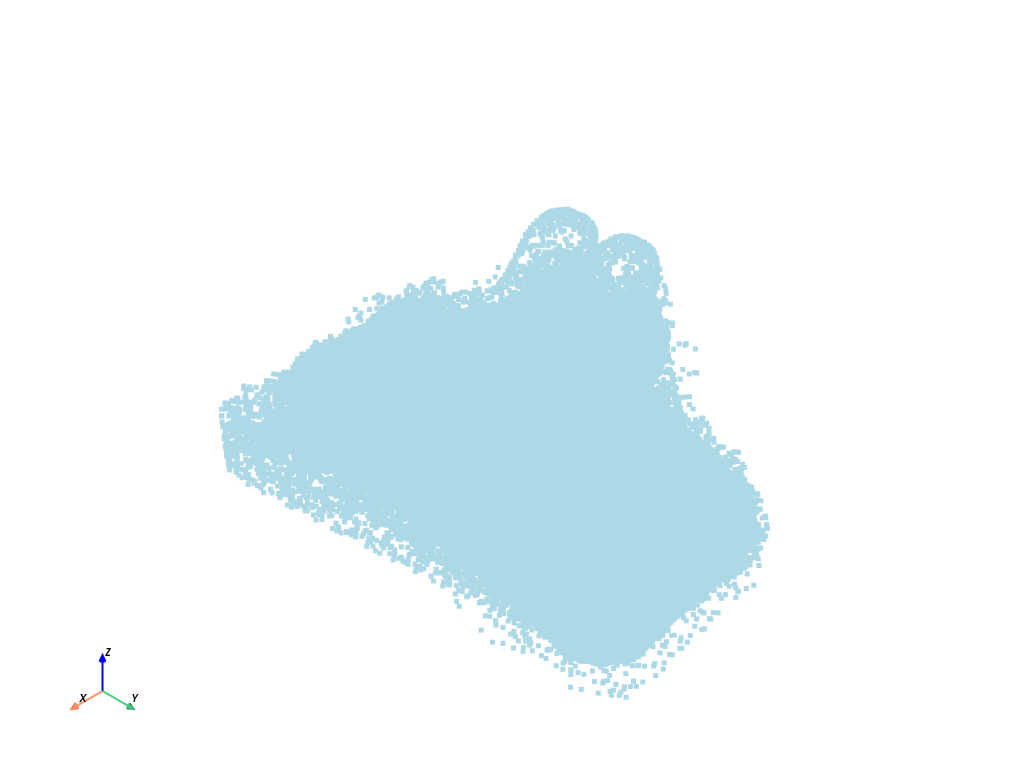

In [8]:
pv_points_downsample.plot()

In [9]:
# names_list = []
# distances = []
for path in tqdm(paths):
    mesh = pv.read(path)
    _ = pv_points_downsample.compute_implicit_distance(mesh, inplace=True)
    with open(data_dir / "SimJEB_cluster_distances" / f"{path.stem}.npy", "wb") as f:
        np.save(f, pv_points_downsample['implicit_distance'])
#     distances.append(pv_points_downsample['implicit_distance'].reshape(-1,1))
    
#     names_list.append(path.stem)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 381/381 [5:21:34<00:00, 50.64s/it]


In [4]:
distances = []
names_list = []
for path in tqdm((data_dir / "SimJEB_cluster_distances").glob("*.npy")):
    names_list.append(path.stem)
    distances.append(np.load(path).reshape((-1,1)))

381it [00:08, 44.82it/s]


In [ ]:
distances = np.hstack(distances)

In [ ]:
embeddings = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(distances)